# Figure showing emergence times of Arctic OLR with confidence intervals

Calculate emergence using the Weatherhead-Shaw approach. When letting the forced response evolve (time dependence), emergence differences between the Weatherhead and Leroy estimates of $\tau_{var}$ were minor. We use the Weatherhead method because it also works for short observational periods.

## Load Data

### Do imports

In [1]:
import sys

sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.

from imports import (
    np, xr, plt, sns, os, 
    glob,
    )

from functions import (
    to_png,
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Methods

#### Weatherhead et al. (1998)

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

Reformulation from Phojan et al. (2014):

$$ [\textrm{Var}(\hat{m})]^{1/2} \approx \left[ \frac{12}{T^3} \textrm{Var}(N_t) \tau_{W}  \right]^{1/2}, $$

where $N_t$ is the demeaned and detrended timeseries and $\tau_W$ is the Weatherhead correlation time given by

$$ \tau_W = \frac{1 + \phi}{1 - \phi}. $$

Time-to-emergence $\Delta t$. Emergence has occured if the length of the record exceeds the time-to-emergence.

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{W} \right]^{1/3}, $$

We will use the expression from Phojanamongkolkij (2014) because it is effectively the same as Leroy with a different expression for the correlation time. We take the lag-1 autocorrelation of the noise (taken from the PI-Control simulation), and the measured noise $\sigma_N$ (taken from the PI-Control simulation).

### Load pre-processed variability and trends

Pre-processing from timeseries to variability and trends is done in trend_uncertainty/spatialdata_preproc.ipynb.

In [2]:
## Define data directory and variables of interest

# Where I saved all of the processed spatial data
spatial_data_dir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/GlobalSpatialTrends/'

# I had issues calculating the variability of FSNTOA and ICEFRAC during normalization.
# Could fix later, but not my focus.
emerge_vars = ['FLUT','TS'] 

Define pre-processing function to revalue lat and lon values so that members 001-035 match nicely with members 101-105.

In [3]:
def preprocess_CESM1_latlons(ds,ens_dim=False):
    
    # Hardcoded latitude and longitude values. It ain't pretty, but it works.
    hard_lats = [-90.  , -89.06, -88.12, -87.17, -86.23, -85.29, -84.35, -83.4 ,
               -82.46, -81.52, -80.58, -79.63, -78.69, -77.75, -76.81, -75.86,
               -74.92, -73.98, -73.04, -72.09, -71.15, -70.21, -69.27, -68.32,
               -67.38, -66.44, -65.5 , -64.55, -63.61, -62.67, -61.73, -60.79,
               -59.84, -58.9 , -57.96, -57.02, -56.07, -55.13, -54.19, -53.25,
               -52.3 , -51.36, -50.42, -49.48, -48.53, -47.59, -46.65, -45.71,
               -44.76, -43.82, -42.88, -41.94, -40.99, -40.05, -39.11, -38.17,
               -37.23, -36.28, -35.34, -34.4 , -33.46, -32.51, -31.57, -30.63,
               -29.69, -28.74, -27.8 , -26.86, -25.92, -24.97, -24.03, -23.09,
               -22.15, -21.2 , -20.26, -19.32, -18.38, -17.43, -16.49, -15.55,
               -14.61, -13.66, -12.72, -11.78, -10.84,  -9.9 ,  -8.95,  -8.01,
                -7.07,  -6.13,  -5.18,  -4.24,  -3.3 ,  -2.36,  -1.41,  -0.47,
                 0.47,   1.41,   2.36,   3.3 ,   4.24,   5.18,   6.13,   7.07,
                 8.01,   8.95,   9.9 ,  10.84,  11.78,  12.72,  13.66,  14.61,
                15.55,  16.49,  17.43,  18.38,  19.32,  20.26,  21.2 ,  22.15,
                23.09,  24.03,  24.97,  25.92,  26.86,  27.8 ,  28.74,  29.69,
                30.63,  31.57,  32.51,  33.46,  34.4 ,  35.34,  36.28,  37.23,
                38.17,  39.11,  40.05,  40.99,  41.94,  42.88,  43.82,  44.76,
                45.71,  46.65,  47.59,  48.53,  49.48,  50.42,  51.36,  52.3 ,
                53.25,  54.19,  55.13,  56.07,  57.02,  57.96,  58.9 ,  59.84,
                60.79,  61.73,  62.67,  63.61,  64.55,  65.5 ,  66.44,  67.38,
                68.32,  69.27,  70.21,  71.15,  72.09,  73.04,  73.98,  74.92,
                75.86,  76.81,  77.75,  78.69,  79.63,  80.58,  81.52,  82.46,
                83.4 ,  84.35,  85.29,  86.23,  87.17,  88.12,  89.06,  90.]
    
    hard_lons = [  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,
                10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
                20.  ,  21.25,  22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,
                30.  ,  31.25,  32.5 ,  33.75,  35.  ,  36.25,  37.5 ,  38.75,
                40.  ,  41.25,  42.5 ,  43.75,  45.  ,  46.25,  47.5 ,  48.75,
                50.  ,  51.25,  52.5 ,  53.75,  55.  ,  56.25,  57.5 ,  58.75,
                60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,  67.5 ,  68.75,
                70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,  78.75,
                80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
                90.  ,  91.25,  92.5 ,  93.75,  95.  ,  96.25,  97.5 ,  98.75,
               100.  , 101.25, 102.5 , 103.75, 105.  , 106.25, 107.5 , 108.75,
               110.  , 111.25, 112.5 , 113.75, 115.  , 116.25, 117.5 , 118.75,
               120.  , 121.25, 122.5 , 123.75, 125.  , 126.25, 127.5 , 128.75,
               130.  , 131.25, 132.5 , 133.75, 135.  , 136.25, 137.5 , 138.75,
               140.  , 141.25, 142.5 , 143.75, 145.  , 146.25, 147.5 , 148.75,
               150.  , 151.25, 152.5 , 153.75, 155.  , 156.25, 157.5 , 158.75,
               160.  , 161.25, 162.5 , 163.75, 165.  , 166.25, 167.5 , 168.75,
               170.  , 171.25, 172.5 , 173.75, 175.  , 176.25, 177.5 , 178.75,
               180.  , 181.25, 182.5 , 183.75, 185.  , 186.25, 187.5 , 188.75,
               190.  , 191.25, 192.5 , 193.75, 195.  , 196.25, 197.5 , 198.75,
               200.  , 201.25, 202.5 , 203.75, 205.  , 206.25, 207.5 , 208.75,
               210.  , 211.25, 212.5 , 213.75, 215.  , 216.25, 217.5 , 218.75,
               220.  , 221.25, 222.5 , 223.75, 225.  , 226.25, 227.5 , 228.75,
               230.  , 231.25, 232.5 , 233.75, 235.  , 236.25, 237.5 , 238.75,
               240.  , 241.25, 242.5 , 243.75, 245.  , 246.25, 247.5 , 248.75,
               250.  , 251.25, 252.5 , 253.75, 255.  , 256.25, 257.5 , 258.75,
               260.  , 261.25, 262.5 , 263.75, 265.  , 266.25, 267.5 , 268.75,
               270.  , 271.25, 272.5 , 273.75, 275.  , 276.25, 277.5 , 278.75,
               280.  , 281.25, 282.5 , 283.75, 285.  , 286.25, 287.5 , 288.75,
               290.  , 291.25, 292.5 , 293.75, 295.  , 296.25, 297.5 , 298.75,
               300.  , 301.25, 302.5 , 303.75, 305.  , 306.25, 307.5 , 308.75,
               310.  , 311.25, 312.5 , 313.75, 315.  , 316.25, 317.5 , 318.75,
               320.  , 321.25, 322.5 , 323.75, 325.  , 326.25, 327.5 , 328.75,
               330.  , 331.25, 332.5 , 333.75, 335.  , 336.25, 337.5 , 338.75,
               340.  , 341.25, 342.5 , 343.75, 345.  , 346.25, 347.5 , 348.75,
               350.  , 351.25, 352.5 , 353.75, 355.  , 356.25, 357.5 , 358.75]
    
    dsnew = ds.copy()
    
    dsnew['lat'] = hard_lats
    
    dsnew['lon'] = hard_lons

    if ens_dim:
        dsnew = dsnew.expand_dims('ens')
    
    return dsnew


def preprocess_CESM1_latlons_LENS(ds):
    
    return preprocess_CESM1_latlons(ds,ens_dim=True)


def preprocess_CESM1_latlons_PIC(ds):
    
    return preprocess_CESM1_latlons(ds,ens_dim=False)


#### Load pre-processed trends

In [10]:
%%time
## Load everything in a lazy way.

trends_list = []

for _var in emerge_vars:

    paths_trends_ann = glob.glob('%s/%s.*.AnnualGlobalSpatialTrends*.nc' % (spatial_data_dir,_var))
    paths_trends_mon = glob.glob('%s/%s.*.GlobalSpatialTrends*.nc' % (spatial_data_dir,_var))
    
    # Sort cause why not?
    paths_trends_ann.sort()
    paths_trends_mon.sort()
    
    # Sub-setting the Arctic in pre-processing causing issues with last 5 members. ??
    trends_ann_ds = xr.open_mfdataset(paths=paths_trends_ann,
                                      preprocess=preprocess_CESM1_latlons_LENS,
                                      # preprocess=lambda ds: ds.expand_dims('ens'),
                                      chunks={'endyear':-1},
                                     )
    
    trends_month_ds = xr.open_mfdataset(paths=paths_trends_mon,
                                        preprocess=preprocess_CESM1_latlons_LENS,
                                        # preprocess=lambda ds: ds.expand_dims('ens'),
                                        chunks={'endyear':-1,'month':1},
                                       )
    
    trends_ann_ds   = trends_ann_ds.sel(lat=slice(60,None))
    trends_month_ds = trends_month_ds.sel(lat=slice(60,None))
    
    trends_all_ds = xr.concat([trends_month_ds,trends_ann_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)],dim='month')
    trends_list.append(trends_all_ds)

trends_all = xr.merge(trends_list)

del trends_all_ds, trends_ann_ds, trends_month_ds,trends_list
    

CPU times: user 1.47 s, sys: 101 ms, total: 1.58 s
Wall time: 10.7 s


#### Load pre-processed variability

In [5]:
%%time
## Load everything in a lazy way.

variab_list = []

for _var in emerge_vars:

    paths_variab_all = glob.glob('%s/%s.GlobalSpatialVariability*.nc' % (spatial_data_dir,_var))

    # Sort cause why not?
    paths_variab_all.sort()
    
    # Sub-setting the Arctic in pre-processing causing issues with last 5 members. ??
    variab_ds = xr.open_mfdataset(paths=paths_variab_all,
                                  preprocess=preprocess_CESM1_latlons_PIC,
                                  # preprocess=lambda ds: ds.expand_dims('ens'),
                                  chunks={'month':1},
                                 )
    
    variab_ds = variab_ds.sel(lat=slice(60,None))
    variab_ds = variab_ds.expand_dims('variable', axis=0).assign_coords(variable=[_var])    
    variab_list.append(variab_ds)
        
variab_all = xr.merge(variab_list)

del variab_ds, variab_list
    

CPU times: user 132 ms, sys: 8.22 ms, total: 140 ms
Wall time: 241 ms


#### 3. Use the Weatherhead/Leroy/Phojanamongkolkij approach to calculate time-to-emergence for each ensemble member

Emergence occurs when the climate signal exits internal variability for the LAST time.

__More extensive code in fig6_OLRemergence_full.ipynb__ I do a comparison between Leroy and Weatherhead there.

Calculate predicted time-to-emergence 

In [6]:
def calc_TTE_from_preproc(varlist,trend_data,variability_data,s=2):
    
    TTE_W_all  = {}
    
    for _var in varlist:
        _stddevs   = variability_data.sel(variable=_var)['stddev']
        _tauvars_W = variability_data.sel(variable=_var)['tauvar_Wea']
        _slopes    = trend_data[_var]

        # time calculated using a correlation time from the lag-1 method 
        _TTE_W  = (12*s**2 * _stddevs**2 * _tauvars_W / _slopes**2)**(1/3)
        _TTE_W.name = _var
        _TTE_W = _TTE_W.drop('variable')

        TTE_W_all[_var]  = _TTE_W

    return xr.merge(TTE_W_all.values())

__Translate to an emergence time (when the signal exits internal variability for the last time).__

In [7]:
def emergence_wrapper(TTE_data,dim='duration'):
    detect_ds = TTE_data < TTE_data.duration
    duration_broad = detect_ds.duration.broadcast_like(detect_ds)
    
    emergence_ds = 1 + duration_broad.where(~detect_ds).max(dim=dim)
    
    return emergence_ds

In [11]:
%%time
# This shouldn't take 10 min. Like 2.5. Memory restrictions slowing.

emergence_list = []

for _var in emerge_vars: # Compute by variable. Perhaps not necessary.
    print(_var)
    _TTE_spatial = calc_TTE_from_preproc([_var],trend_data=trends_all,variability_data=variab_all)
    
    _TTE_spatial_comp = _TTE_spatial.compute()
    _emergence_spatial = emergence_wrapper(_TTE_spatial_comp,dim='endyear')

    # _emergence_spatial = emergence_wrapper(_TTE_spatial,dim='endyear')
    
    emergence_list.append(_emergence_spatial.compute())
    
emergence_ds = xr.merge(emergence_list)
    

FLUT
TS
CPU times: user 1min 2s, sys: 49.3 s, total: 1min 51s
Wall time: 4min 26s


In [54]:
# Save processed output
emergence_ds.to_netcdf('spatial_TTE_arctic_OLR_TS.nc')

In [12]:
emergence_mean = emergence_ds.mean(dim='ens')

In [13]:
from functions import (add_map_features,
                       sp_map,
                       polarCentral_set_latlim,
                      )
from imports   import ccrs

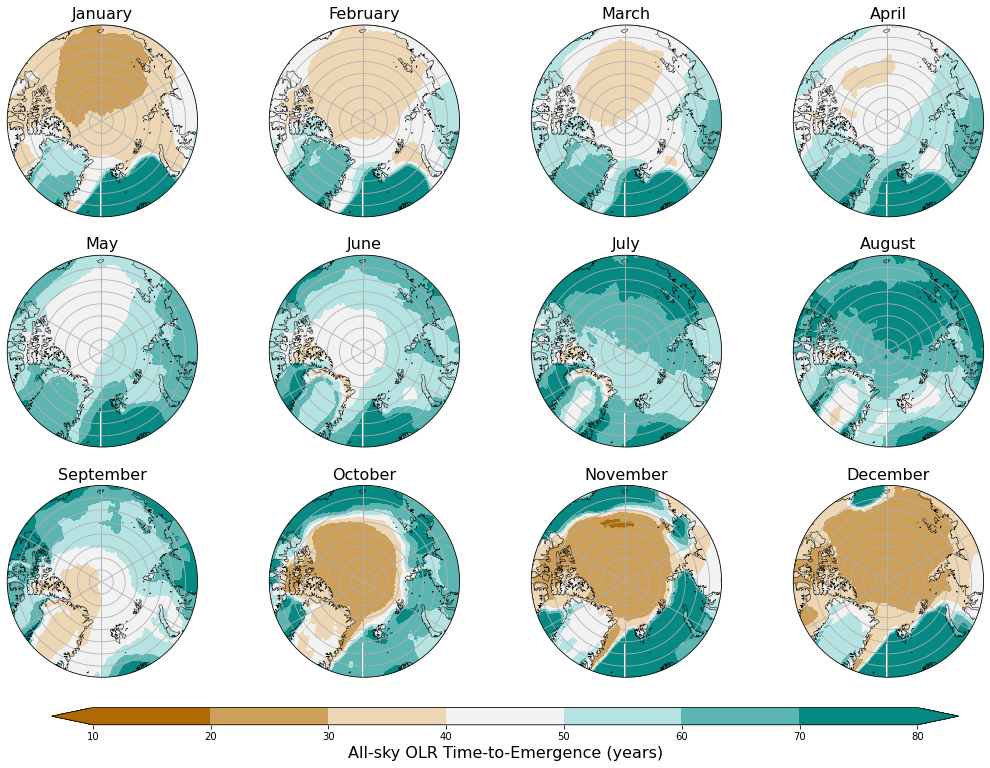

In [42]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

data = emergence_mean
var = 'FLUT'

fig,axs = sp_map(nrows=3, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

# palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)
# palette = sns.diverging_palette(h_neg=42, h_pos=186, s=99, l=51, sep=35, n=7, as_cmap=True)
palette = sns.diverging_palette(h_neg=42, h_pos=186, s=99, l=51, sep=35, n=7, as_cmap=False)

for i,ax in enumerate(axs.flat):
    
    month = emergence_mean[var].isel(month=i)
    
    polarCentral_set_latlim([70,90], ax)
    
    im = ax.contourf(month['lon'],month['lat'],month,
                     transform=ccrs.PlateCarree(),
                     # cmap=palette,
                     colors=palette,
                     levels=np.linspace(10,80,8),
                     extend='both',
                     vmin=0,vmax=80,
                    )
    
    add_map_features(ax)
    
    label = mon_dict[str(i+1)]
    
    ax.set_title(label,fontsize=16)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("All-sky OLR Time-to-Emergence (years)",fontsize=16)

In [43]:
to_png(file=fig,filename='fig_spatialOLRemergence_monthly',dpi=300,ext='pdf',bbox_inches='tight')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


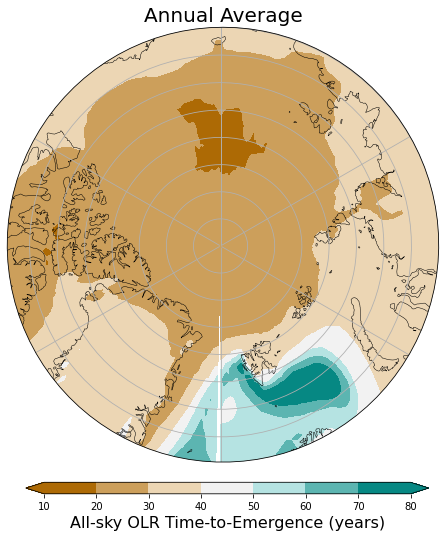

In [50]:
data = emergence_mean
var = 'FLUT'

fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

palette = sns.diverging_palette(h_neg=42, h_pos=186, s=99, l=51, sep=35, n=7, as_cmap=False)
    
month = emergence_mean[var].isel(month=12)
    
polarCentral_set_latlim([70,90], ax)

im = ax.contourf(month['lon'],month['lat'],month,
                 transform=ccrs.PlateCarree(),
                 # cmap=palette,
                 colors=palette,
                 levels=np.linspace(10,80,8),
                 extend='both',
                 vmin=0,vmax=80,
                )

add_map_features(ax)

label = 'Annual Average'

ax.set_title(label,fontsize=20)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("All-sky OLR Time-to-Emergence (years)",fontsize=16)

In [45]:
to_png(file=fig,filename='fig_spatialOLRemergence_annual',dpi=300,ext='pdf',bbox_inches='tight')

#### Combine March and April so that everything can fit into a 12-panel plot.

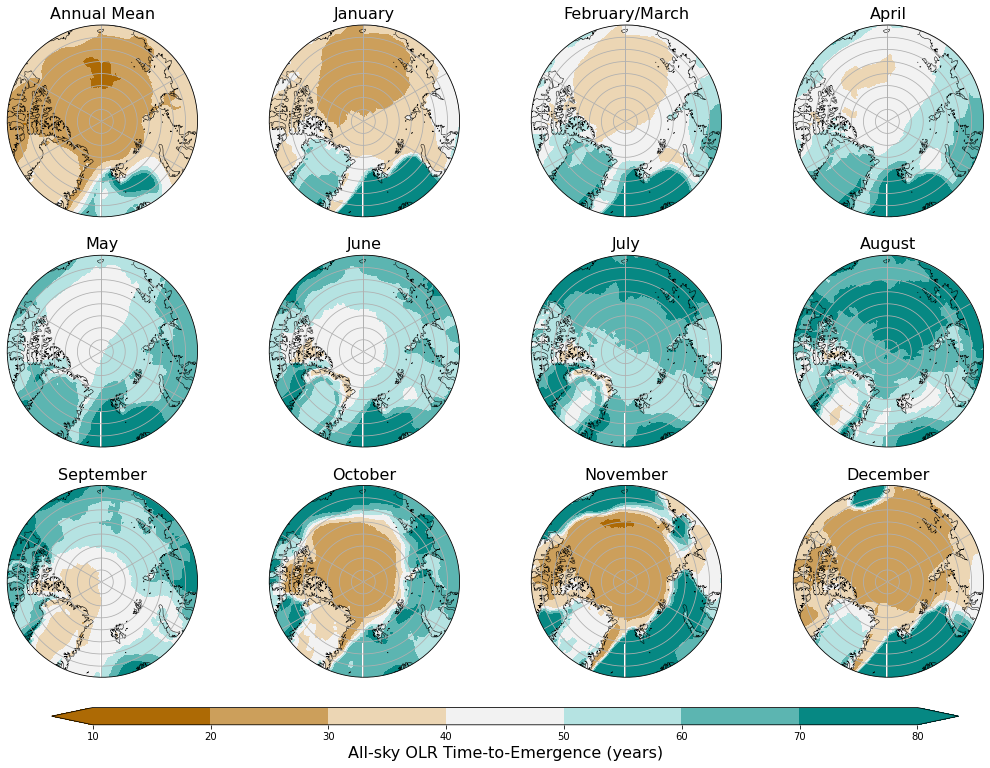

In [73]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

data = emergence_mean
var = 'FLUT'

fig,axs = sp_map(nrows=3, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

# palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)
# palette = sns.diverging_palette(h_neg=42, h_pos=186, s=99, l=51, sep=35, n=7, as_cmap=True)
palette = sns.diverging_palette(h_neg=42, h_pos=186, s=99, l=51, sep=35, n=7, as_cmap=False)

ax0 = axs.flat[0]

ann = emergence_mean[var].sel(month=13)
polarCentral_set_latlim([70,90], ax0)

im = ax0.contourf(ann['lon'],ann['lat'],ann,
                 transform=ccrs.PlateCarree(),
                 colors=palette,
                 levels=np.linspace(10,80,8),
                 extend='both',
                 vmin=0,vmax=80,
                )

add_map_features(ax0)

label = 'Annual Mean'

ax0.set_title(label,fontsize=16)

# Combine February and March for space's sake
part1 = emergence_mean[var].sel(month=1)
part2 = emergence_mean[var].sel(month=slice(2,3)).mean(dim='month')
part2 = part2.assign_coords({'month':2.5}).expand_dims('month',axis=-1)
part3 = emergence_mean[var].sel(month=slice(4,12))
sliced_tte = xr.concat([part1,part2,part3],dim='month')

sliced_dict = {'1.0':'January','2.5':'February/March','3.0':'March','4.0':'April','5.0':'May','6.0':'June',
               '7.0':'July','8.0':'August','9.0':'September','10.0':'October','11.0':'November','12.0':'December',
              }
                                
for i,ax in enumerate(axs.flat[1:]):
    
    # month = emergence_mean[var].isel(month=i)
    month = sliced_tte.isel(month=i)
    month_i = str(month.month.values.round(1))
    
    polarCentral_set_latlim([70,90], ax)
    
    im = ax.contourf(month['lon'],month['lat'],month,
                     transform=ccrs.PlateCarree(),
                     colors=palette,
                     levels=np.linspace(10,80,8),
                     extend='both',
                     vmin=0,vmax=80,
                    )
    
    add_map_features(ax)
    
    label = sliced_dict[month_i]
    # label = mon_dict[str(i+1)]
    
    ax.set_title(label,fontsize=16)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("All-sky OLR Time-to-Emergence (years)",fontsize=16)

In [74]:
to_png(file=fig,filename='fig_spatialOLRemergence_annmonth',dpi=300,ext='pdf',bbox_inches='tight')

#### Surface Temperature

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


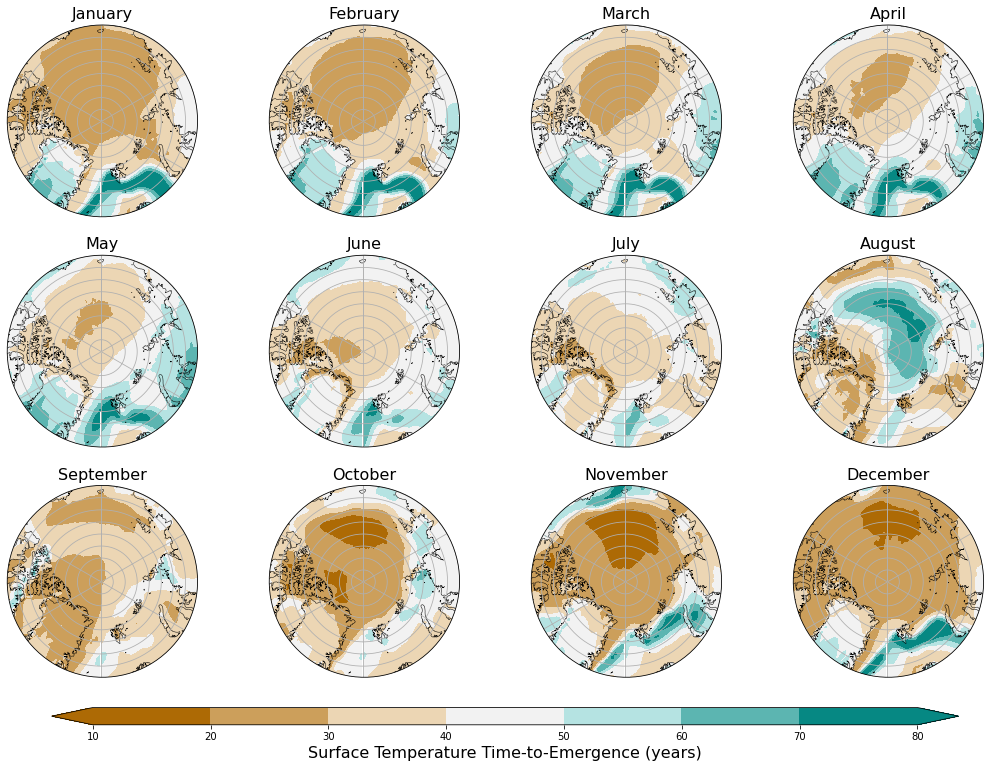

In [46]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

data = emergence_mean
var = 'TS'

fig,axs = sp_map(nrows=3, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

# palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)
# palette = sns.diverging_palette(h_neg=42, h_pos=186, s=99, l=51, sep=35, n=7, as_cmap=True)
palette = sns.diverging_palette(h_neg=42, h_pos=186, s=99, l=51, sep=35, n=7, as_cmap=False)

for i,ax in enumerate(axs.flat):
    
    month = emergence_mean[var].isel(month=i)
    
    polarCentral_set_latlim([70,90], ax)
    
    im = ax.contourf(month['lon'],month['lat'],month,
                     transform=ccrs.PlateCarree(),
                     # cmap=palette,
                     colors=palette,
                     levels=np.linspace(10,80,8),
                     extend='both',
                     vmin=0,vmax=80,
                    )
    
    add_map_features(ax)
    
    label = mon_dict[str(i+1)]
    
    ax.set_title(label,fontsize=16)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("Surface Temperature Time-to-Emergence (years)",fontsize=16)

In [47]:
to_png(file=fig,filename='fig_spatialTSemergence_monthly',dpi=300,ext='pdf',bbox_inches='tight')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


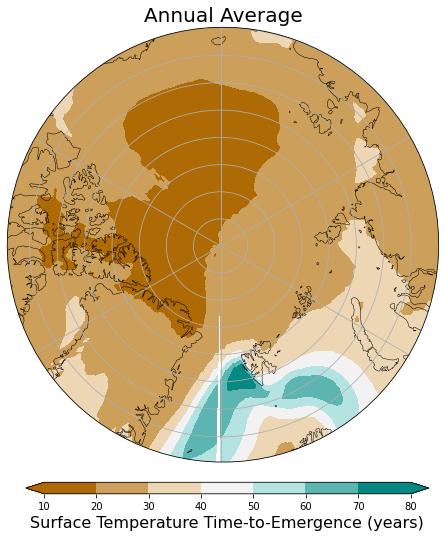

In [48]:
data = emergence_mean
var = 'TS'

fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

palette = sns.diverging_palette(h_neg=42, h_pos=186, s=99, l=51, sep=35, n=7, as_cmap=False)
    
month = emergence_mean[var].isel(month=12)
    
polarCentral_set_latlim([70,90], ax)

im = ax.contourf(month['lon'],month['lat'],month,
                 transform=ccrs.PlateCarree(),
                 # cmap=palette,
                 colors=palette,
                 levels=np.linspace(10,80,8),
                 extend='both',
                 vmin=0,vmax=80,
                )

add_map_features(ax)

label = 'Annual Average'

ax.set_title(label,fontsize=20)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("Surface Temperature Time-to-Emergence (years)",fontsize=16)

In [49]:
to_png(file=fig,filename='fig_spatialTSemergence_annual',dpi=300,ext='pdf',bbox_inches='tight')

__Add asymmetry and use bootstrapping to limit the effect outliers.__

_Weatherhead estimates bootstrapped -->_

In [103]:
def bootstrap_CIs(data_ds,
                  nbootstraps=3000,
                  alpha=0.95,
                  axis=1,
                  coords_dict=dict(
                      # bound=[lower_bound,50,upper_bound], # bounds are percentiles now
                      month=np.arange(1,14,1),
                  )
                 ):
    
    N_ens = len(data_ds['ens']) # number of members
    gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array

    # Compute percentiles using bootstrapping
    lower_percentile = []
    upper_percentile = []
    mean_emergence = []

    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 1)
        resample_emergence = gen.choice(data_ds, size=N_ens, replace=True,axis=axis)
        # compute percentiles along the ensemble dimension (axis 1)
        lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=axis))
        upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=axis))
        mean_emergence.append(np.mean(resample_emergence,axis=axis))

    _lower_emerge_bstrap = np.mean(lower_percentile,axis=0) # take the mean percentile along the correct axis
    _upper_emerge_bstrap = np.mean(upper_percentile,axis=0)
    _mean_emerge_bstrap  = np.mean(mean_emergence,axis=0)

    time_coord = list(coords_dict.keys())[0]
    coords_dict['bound'] = [lower_bound,50,upper_bound]

    _emergence_LP_da = xr.DataArray(
        data=np.array([_lower_emerge_bstrap,_mean_emerge_bstrap,_upper_emerge_bstrap]),
        dims=["bound",time_coord],
        coords=coords_dict,
        # name = _var
    )
    
    # _emergence_LP_da = xr.DataArray(
    #     data=np.array([_lower_emerge_bstrap,_mean_emerge_bstrap,_upper_emerge_bstrap]),
    #     dims=["bound","month"],
    #     coords=dict(
    #         bound=[lower_bound,50,upper_bound], # bounds are percentiles now
    #         month=np.arange(1,14,1),
    #     ),
    #     # name = _var
    # )
    
    return _emergence_LP_da

In [91]:
emergence_W_day15

<xarray.Dataset>
Dimensions:    (dayofyear: 24, ens: 40)
Coordinates:
  * dayofyear  (dayofyear) int64 8 23 38 53 68 83 98 ... 278 293 308 323 338 353
  * ens        (ens) int64 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 101 102 103 104 105
Data variables:
    FLUT       (dayofyear, ens) float64 35.0 31.0 39.0 33.0 ... 19.0 31.0 31.0
    TS         (dayofyear, ens) float64 34.0 29.0 23.0 19.0 ... 15.0 20.0 28.0
    ICEFRAC    (dayofyear, ens) float64 43.0 28.0 44.0 38.0 ... 19.0 21.0 30.0
    FSNTOA     (dayofyear, ens) float64 81.0 81.0 81.0 81.0 ... 81.0 81.0 81.0

In [113]:
%time

# Bootstrap 95% confidence intervals

# These dictionaries tell the function how to organize the output after bootstrapping.
day1_coords_dict = dict(dayofyear=emergence_W_day1['dayofyear'],
                       )

day5_coords_dict = dict(dayofyear=emergence_W_day5['dayofyear'],
                       )

day15_coords_dict = dict(dayofyear=emergence_W_day15['dayofyear'],
                        )

# What day of the year is the 15th day of each month? Last (366) is for annual avg.
dayofyear_middlemonth = [15,46,74,105,135,166,196,227,258,288,319,349,366] 
month1_coords_dict = dict(dayofyear=dayofyear_middlemonth, 
                         )

emergence_W_CI_day1   = emergence_W_day1.map(bootstrap_CIs,coords_dict=day1_coords_dict)

emergence_W_CI_day5   = emergence_W_day5.map(bootstrap_CIs,coords_dict=day5_coords_dict)

emergence_W_CI_day15  = emergence_W_day15.map(bootstrap_CIs,coords_dict=day15_coords_dict)

emergence_W_CI_month1 = emergence_W_month1.map(bootstrap_CIs,coords_dict=month1_coords_dict)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


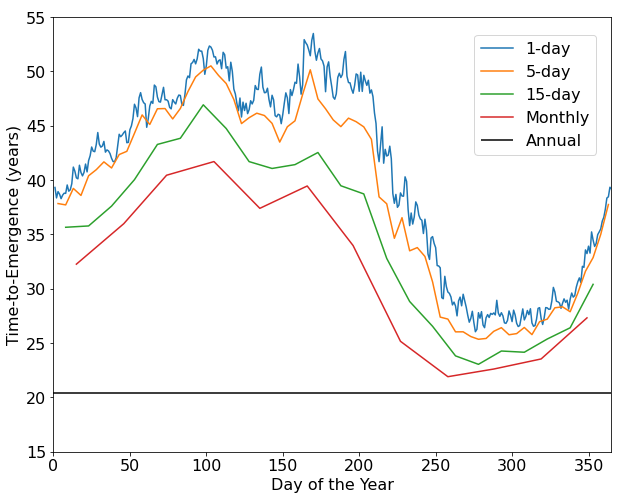

In [142]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

plt.plot(emergence_W_CI_day1['dayofyear'],emergence_W_CI_day1['FLUT'].sel(bound=50),
         label='1-day',
        )

plt.plot(emergence_W_CI_day5['dayofyear'],emergence_W_CI_day5['FLUT'].sel(bound=50),
         label='5-day',
        )

plt.plot(emergence_W_CI_day15['dayofyear'],emergence_W_CI_day15['FLUT'].sel(bound=50),
         label='15-day',
        )

plt.plot(emergence_W_CI_month1['dayofyear'][:12],emergence_W_CI_month1['FLUT'].sel(bound=50)[:12],
         label='Monthly',
        )


plt.hlines(y=emergence_W_CI_month1['FLUT'].sel(bound=50)[-1],xmin=0,xmax=365,
          color='black',
          label='Annual'
          )

ax.set_xlim(0,365)
ax.set_ylim(15,55)

ax.set_xlabel('Day of the Year',fontsize=16)
ax.set_ylabel('Time-to-Emergence (years)',fontsize=16)

ax.tick_params(axis='both',labelsize=16)

fig.legend(loc=(0.75,0.69),fontsize=16)


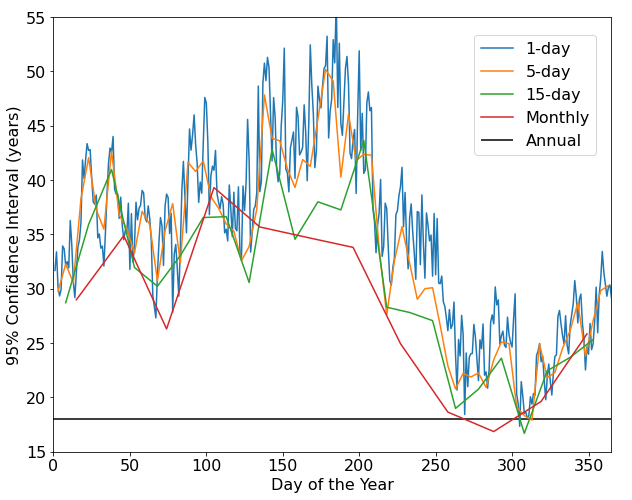

In [146]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

# Calculate the width of the CIs
day1_FLUT_CI   = emergence_W_CI_day1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day1['FLUT'].sel(bound=2.5,method='nearest')
day5_FLUT_CI   = emergence_W_CI_day5['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day5['FLUT'].sel(bound=2.5,method='nearest')
day15_FLUT_CI  = emergence_W_CI_day15['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day15['FLUT'].sel(bound=2.5,method='nearest')
month1_FLUT_CI = emergence_W_CI_month1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_month1['FLUT'].sel(bound=2.5,method='nearest')
year1_FLUT_CI  = month1_FLUT_CI[-1]

plt.plot(emergence_W_CI_day1['dayofyear'],day1_FLUT_CI,
         label='1-day',
        )

plt.plot(emergence_W_CI_day5['dayofyear'],day5_FLUT_CI,
         label='5-day',
        )

plt.plot(emergence_W_CI_day15['dayofyear'],day15_FLUT_CI,
         label='15-day',
        )

plt.plot(emergence_W_CI_month1['dayofyear'][:12],month1_FLUT_CI[:12],
         label='Monthly',
        )

plt.hlines(y=year1_FLUT_CI,xmin=0,xmax=365,
          color='black',
          label='Annual'
          )

ax.set_xlim(0,365)
ax.set_ylim(15,55)

ax.set_xlabel('Day of the Year',fontsize=16)
ax.set_ylabel('95% Confidence Interval (years)',fontsize=16)

ax.tick_params(axis='both',labelsize=16)

fig.legend(loc=(0.75,0.69),fontsize=16)


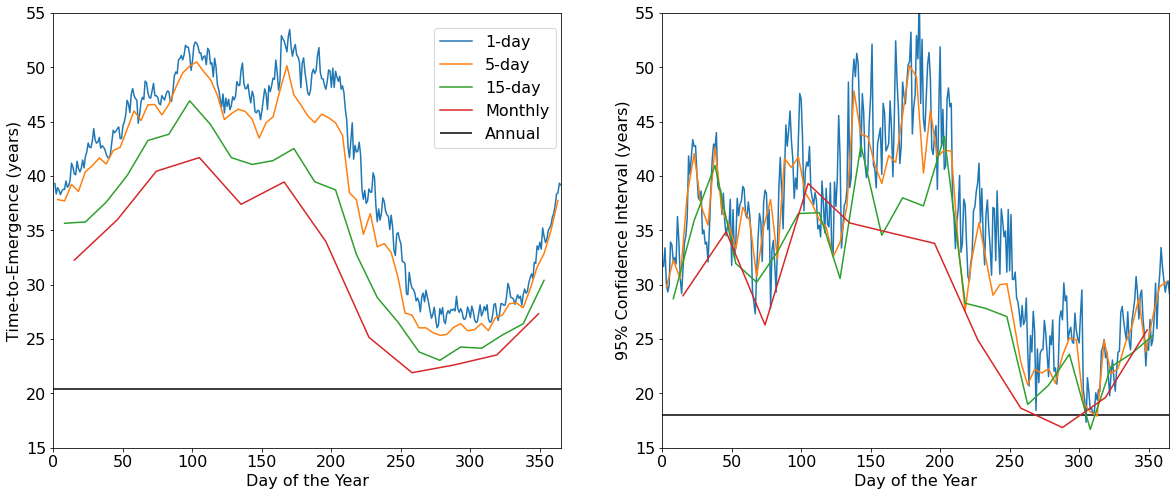

In [151]:
fig,ax = plt.subplots(1,2,figsize=(20,8))

# Calculate the width of the CIs
day1_FLUT_CI   = emergence_W_CI_day1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day1['FLUT'].sel(bound=2.5,method='nearest')
day5_FLUT_CI   = emergence_W_CI_day5['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day5['FLUT'].sel(bound=2.5,method='nearest')
day15_FLUT_CI  = emergence_W_CI_day15['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_day15['FLUT'].sel(bound=2.5,method='nearest')
month1_FLUT_CI = emergence_W_CI_month1['FLUT'].sel(bound=97.5,method='nearest') - emergence_W_CI_month1['FLUT'].sel(bound=2.5,method='nearest')
year1_FLUT_CI  = month1_FLUT_CI[-1]

# Plot the Mean TTE
ax[0].plot(emergence_W_CI_day1['dayofyear'],emergence_W_CI_day1['FLUT'].sel(bound=50),
           label='1-day',
          )

ax[0].plot(emergence_W_CI_day5['dayofyear'],emergence_W_CI_day5['FLUT'].sel(bound=50),
           label='5-day',
          )

ax[0].plot(emergence_W_CI_day15['dayofyear'],emergence_W_CI_day15['FLUT'].sel(bound=50),
           label='15-day',
          )

ax[0].plot(emergence_W_CI_month1['dayofyear'][:12],emergence_W_CI_month1['FLUT'].sel(bound=50)[:12],
           label='Monthly',
          )


ax[0].hlines(y=emergence_W_CI_month1['FLUT'].sel(bound=50)[-1],xmin=0,xmax=365,
            color='black',
            label='Annual'
            )

# Plot the width of the CIs
ax[1].plot(emergence_W_CI_day1['dayofyear'],day1_FLUT_CI,
           label='1-day',
          )

ax[1].plot(emergence_W_CI_day5['dayofyear'],day5_FLUT_CI,
           label='5-day',
          )

ax[1].plot(emergence_W_CI_day15['dayofyear'],day15_FLUT_CI,
           label='15-day',
          )

ax[1].plot(emergence_W_CI_month1['dayofyear'][:12],month1_FLUT_CI[:12],
           label='Monthly',
          )

ax[1].hlines(y=year1_FLUT_CI,xmin=0,xmax=365,
             color='black',
             label='Annual'
            )

ax[0].set_xlim(0,365)
ax[0].set_ylim(15,55)

ax[0].set_xlabel('Day of the Year',fontsize=16)
ax[0].set_ylabel('Time-to-Emergence (years)',fontsize=16)

ax[1].set_xlim(0,365)
ax[1].set_ylim(15,55)

ax[1].set_xlabel('Day of the Year',fontsize=16)
ax[1].set_ylabel('95% Confidence Interval (years)',fontsize=16)

ax[0].tick_params(axis='both',labelsize=16)
ax[1].tick_params(axis='both',labelsize=16)

ax[0].legend(loc=(0.75,0.69),fontsize=16)


In [154]:
to_png(fig,filename='OLR_emergence_temporalscales',dpi=300,ext='pdf',bbox_inches='tight')

- When there is less variability, you reach the averaging floor more quickly. We can see that the monthly averages are always lower than the 15-day averages, but in September they start to get close together.

- Averaging reduces the average TTE. But the 95% confidence interval is pretty constant. I'd expect a much larger 95% confidence interval with the higher frequency data, but I guess that's not the case.